# 


In [3]:
!pip install protobuf==3.20.3

  Using cached protobuf-3.20.3-cp310-cp310-win_amd64.whl.metadata (698 bytes)
Using cached protobuf-3.20.3-cp310-cp310-win_amd64.whl (904 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.8
    Uninstalling protobuf-4.25.8:
      Successfully uninstalled protobuf-4.25.8


  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mediapipe 0.10.21 requires protobuf<5,>=4.25.3, but you have protobuf 3.20.3 which is incompatible.
tensorboard 2.10.1 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
tensorflow 2.10.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.


In [5]:
import os
os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"

In [6]:
import os
import random
import numpy as np
import tensorflow as tf

SEED=42
os.environ["PYTHONHASHSEED"]=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

TypeError: Descriptors cannot be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates

In [2]:
# GPU 설정
gpus=tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Input, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
IMG_SIZE=86
BATCH_SIZE=32
DATA_PATH="../../data/processed/02_kaggle_dataset/train"

datagen=ImageDataGenerator(
    rescale=1./255,
    brightness_range=[0.7, 1.3],
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode="nearest",
    horizontal_flip=False,
    validation_split=0.2
)

train_generator=datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="training",
    shuffle=True,
    seed=SEED
)

val_generator=datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation",
    shuffle=False
)

input_shape = (IMG_SIZE, IMG_SIZE, 3)
base_model = ResNet50V2(include_top=False, weights="imagenet", input_shape=input_shape)
base_model.trainable = False

inputs = Input(shape=input_shape)
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.4)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss="binary_crossentropy",
              metrics=["accuracy"])

Found 38400 images belonging to 2 classes.
Found 9600 images belonging to 2 classes.


In [5]:
# Dropout 증가 + L2 + Dense 노드 축소
# model=Sequential([
#     Conv2D(64, 3, activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 1)),
#     BatchNormalization(),
#     MaxPooling2D(2),

#     Conv2D(96, 3, activation="relu"),
#     BatchNormalization(),
#     MaxPooling2D(2),

#     Flatten(),
#     Dense(32, activation="relu", kernel_regularizer=l2(0.001)),  # Dense 노드 축소 + 정규화
#     Dropout(0.4),  # Dropout 증가
#     Dense(1, activation="sigmoid")
# ])

# model.compile(optimizer=Adam(learning_rate=0.0005),
#             loss="binary_crossentropy", metrics=["accuracy"])

In [6]:
history=model.fit(train_generator, validation_data=val_generator,
                epochs=20, verbose=1)

Epoch 1/20
1200/1200 [==============================] - 85s 68ms/step - loss: 0.1985 - accuracy: 0.9228 - val_loss: 0.1776 - val_accuracy: 0.9243
Epoch 2/20
1200/1200 [==============================] - 81s 67ms/step - loss: 0.1261 - accuracy: 0.9540 - val_loss: 0.1543 - val_accuracy: 0.9360
Epoch 3/20
1200/1200 [==============================] - 81s 67ms/step - loss: 0.1073 - accuracy: 0.9612 - val_loss: 0.2173 - val_accuracy: 0.9129
Epoch 4/20
1200/1200 [==============================] - 80s 67ms/step - loss: 0.1017 - accuracy: 0.9621 - val_loss: 0.1713 - val_accuracy: 0.9321
Epoch 5/20
1200/1200 [==============================] - 80s 67ms/step - loss: 0.0969 - accuracy: 0.9658 - val_loss: 0.1792 - val_accuracy: 0.9253
Epoch 6/20
1200/1200 [==============================] - 80s 67ms/step - loss: 0.0923 - accuracy: 0.9664 - val_loss: 0.1845 - val_accuracy: 0.9234
Epoch 7/20
1200/1200 [==============================] - 80s 67ms/step - loss: 0.0860 - accuracy: 0.9684 - val_loss: 0.1772 -

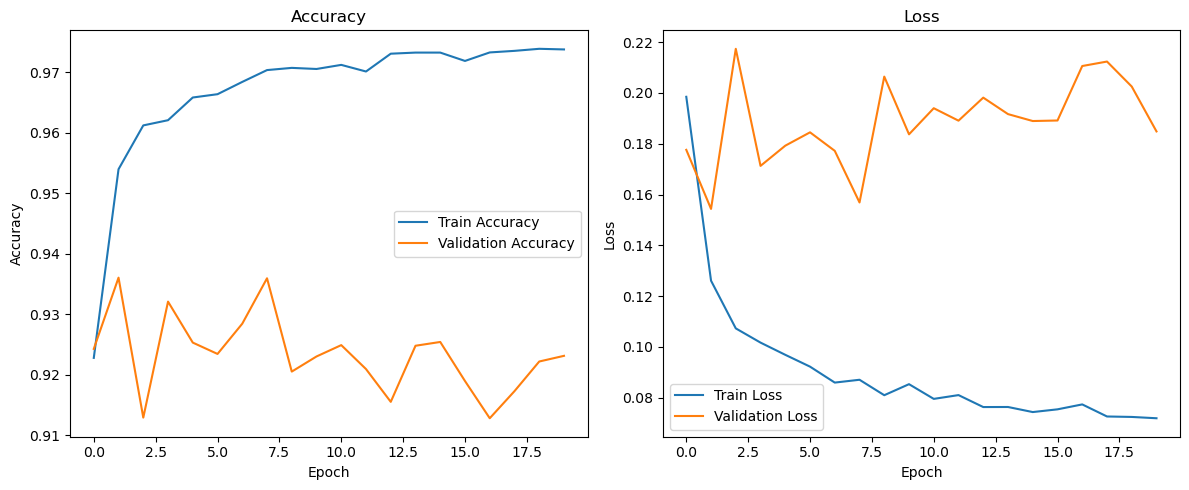

In [7]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.savefig("../../results/images/02_readjusted_training_plot.png")
plt.show()

              precision    recall  f1-score   support

      closed       0.87      0.98      0.93      4800
        open       0.98      0.86      0.92      4800

    accuracy                           0.92      9600
   macro avg       0.93      0.92      0.92      9600
weighted avg       0.93      0.92      0.92      9600



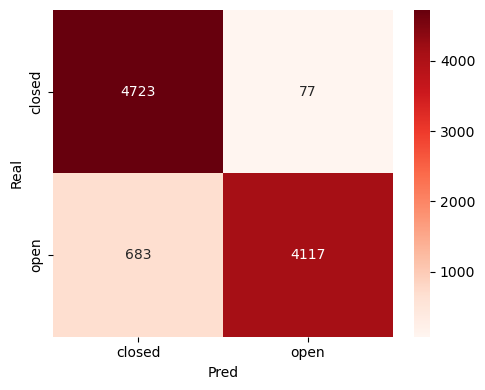

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_true=val_generator.classes
steps=val_generator.samples // val_generator.batch_size + 1
y_pred_prob=model.predict(val_generator, steps=steps, verbose=0)
y_pred=(y_pred_prob > 0.5).astype(int)

# classification report
report=classification_report(y_true, y_pred, target_names=["closed", "open"])
print(report)
with open("../../results/reports/01_resnet_classification_report.txt", "w") as f:
    f.write(report)

# confusion matrix
conf_matirx=confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matirx, annot=True, fmt="d", cmap="Reds",
            xticklabels=["closed", "open"], yticklabels=["closed", "open"])
plt.xlabel("Pred")
plt.ylabel("Real")
plt.tight_layout()
plt.savefig("../../results/images/01_resnet_confusion_matrix.png")
plt.show()

In [11]:
os.makedirs("../../src/models/09_ResNet_Model", exist_ok=True)
model.save("../../src/models/09_ResNet_Model/readjusted_model.keras")